In [41]:
import os, numpy as np, config
from PIL import Image, ImageDraw

# ------------------------------------------------------------------ constants
SIDE   = 224                      # target size (square)
S      = config.S
ANCHOR = config.ANCHORS[0]        # (w₀, h₀) in relative units

# ------------------------------------------------------------------ helpers
def _rel2abs(cx, cy, w, h):
    """Relative 0-1 centre/size  →  absolute pixel corners (896×896)."""
    cx, cy, w, h = cx*SIDE, cy*SIDE, w*SIDE, h*SIDE
    return [cx - w/2, cy - h/2, cx + w/2, cy + h/2]

def _gt_box_from_row(row):
    """Decode (cx,cy,tx,ty,tw,th) row to absolute pixel rectangle."""
    cx = (row.cx + row.tx) / S
    cy = (row.cy + row.ty) / S
    w  = np.exp(row.tw) * ANCHOR[0]
    h  = np.exp(row.th) * ANCHOR[1]
    return _rel2abs(cx, cy, w, h)

# ------------------------------------------------------------------ main
def render_gt(gt_df, img_id,
              *, colour=(0, 255, 0, 200),
              out_dir="evaluation",
              size=SIDE):
    ann = gt_df[gt_df.img_id == img_id]
    if ann.empty:
        raise ValueError(f"no rows with img_id={img_id}")

    img_path = os.path.join(config.img_dir, ann.filename.iloc[0])
    pil = Image.open(img_path).convert("RGB").resize((size, size))

    draw = ImageDraw.Draw(pil, "RGBA")
    for _, row in ann.iterrows():
        draw.rectangle(_gt_box_from_row(row), outline=colour, width=2)

    os.makedirs(out_dir, exist_ok=True)
    out_path = os.path.join(out_dir, f"{img_id}_gt_only.png")
    pil.save(out_path)
    print(f"[render_gt] saved → {out_path}")
    return pil

In [8]:
import util
from importlib import reload
import model as m

reload(util)
reload(config)

de = util.DataExtractor()
gt_df = de.croppedData()


Saving to: c:\Users\alexh\Desktop\cv2\obb_anns_hausarbeit\ds2_dense\ds2_dense\gt_space.json


[render_gt] saved → evaluation\1023_gt_only.png


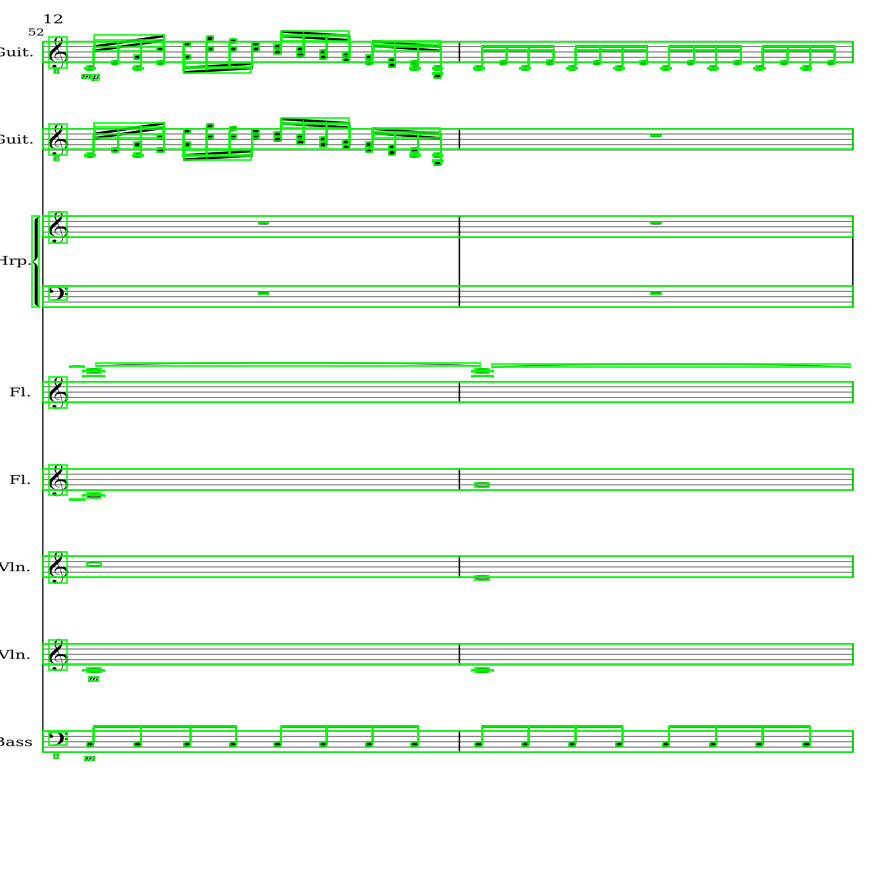

In [10]:
render_gt(gt_df, img_id=1023)

## Predictions

In [11]:
import pandas as pd
import util
from importlib import reload

reload(util)
reload(config)
gt_df = util.DataExtractor().croppedData()

Saving to: c:\Users\alexh\Desktop\cv2\obb_anns_hausarbeit\ds2_dense\ds2_dense\gt_space.json


In [42]:
import os, numpy as np, config
from PIL import Image, ImageDraw


def render_crop_gt(
        gt_df, img_id,
        *, crop_cells, row_idx, col_idx,
        colour=(255, 0, 0, 200),
        out_dir="evaluation_crops",
        size=SIDE):
    
    """size       : output edge length (kept 896 for parity)"""

    if S % crop_cells:
        raise ValueError(f"crop_cells={crop_cells} must divide {S}")
    crops_per_dim = S // crop_cells
    if not (0 <= row_idx < crops_per_dim and 0 <= col_idx < crops_per_dim):
        raise ValueError("row_idx / col_idx outside valid range")

    page = gt_df[gt_df.img_id == img_id]
    if page.empty:
        raise ValueError(f"No rows with img_id={img_id}")

    # ---------- crop window in cell coordinates --------------------------------
    cx_min = col_idx * crop_cells
    cx_max = (col_idx + 1) * crop_cells       # exclusive
    cy_min = row_idx * crop_cells
    cy_max = (row_idx + 1) * crop_cells

    crop_boxes = page[(page.cx >= cx_min) & (page.cx < cx_max) &
                      (page.cy >= cy_min) & (page.cy < cy_max)]
    if crop_boxes.empty:
        raise ValueError("No GT boxes inside the requested crop")

    # ---------- prepare full-page canvas (896×896) ------------------------------
    img_path = os.path.join(config.img_dir, crop_boxes.filename.iloc[0])
    full = Image.open(img_path).convert("RGB").resize((SIDE, SIDE))

    # pixel window of the crop on that 896×896 full canvas
    cell_px   = SIDE / S                       # width/height of one grid cell
    crop_px   = crop_cells * cell_px           # edge length of the crop region
    left_px   = int(round(col_idx * crop_px))
    top_px    = int(round(row_idx * crop_px))
    right_px  = int(round(left_px + crop_px))
    lower_px  = int(round(top_px  + crop_px))

    # cut & upscale to full 896×896 preview
    crop_img  = full.crop((left_px, top_px, right_px, lower_px)).resize((size, size))
    scale     = size / (right_px - left_px)    # same for x and y

    # ---------- draw ------------------------------------------------------------
    draw = ImageDraw.Draw(crop_img, "RGBA")
    for _, row in crop_boxes.iterrows():
        x0, y0, x1, y1 = _gt_box_from_row(row)
        # shift into crop coords, then upscale
        box = [(x0 - left_px) * scale,
               (y0 - top_px)  * scale,
               (x1 - left_px) * scale,
               (y1 - top_px)  * scale]
        draw.rectangle(box, outline=colour, width=2)

    # ---------- save / return ---------------------------------------------------
    os.makedirs(out_dir, exist_ok=True)
    name = f"{img_id}_r{row_idx}_c{col_idx}_cells{crop_cells}.png"
    out_path = os.path.join(out_dir, name)
    crop_img.save(out_path)
    print(f"[render_crop_gt] saved → {out_path}")
    return crop_img


[render_crop_gt] saved → evaluation_crops\895_r0_c8_cells10.png


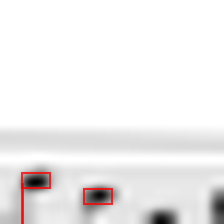

In [43]:
render_crop_gt(gt_df,
               img_id=895,
               crop_cells=10,
               row_idx=0,
               col_idx=8)

In [ ]:
import os, numpy as np, config
from PIL import Image, ImageDraw

SIDE = 896

N      = config.N            # 40
S_OVER_N = S / N             # 3.0

def render_crop_gt_loc(df, img_id,
                       *, crop_id=None, crop_row=None, crop_col=None,
                       colour=(0, 255, 0, 200),
                       out_dir="evaluation_crops_loc",
                       size=SIDE):
    subset = df[df.img_id == img_id]
    if subset.empty:
        raise ValueError(f"img_id {img_id} not in dataframe")

    # ---------------------------------------------------------------- pick crop
    if crop_id is not None:
        crop_rows = subset[subset.crop_id == crop_id]
        if crop_rows.empty:
            valid = sorted(subset.crop_id.unique())
            raise ValueError(f"crop_id {crop_id} not found for img_id {img_id}.\n"
                             f"Valid crop_id values: {valid[:20]}…")
        crop_row = int(crop_rows.crop_row.iloc[0])
        crop_col = int(crop_rows.crop_col.iloc[0])
    else:
        if crop_row is None or crop_col is None:
            raise ValueError("Pass either crop_id or both crop_row and crop_col")
        crop_rows = subset[(subset.crop_row == crop_row) &
                           (subset.crop_col == crop_col)]
        if crop_rows.empty:
            raise ValueError(f"No rows at crop_row={crop_row}, crop_col={crop_col}")

    # ---------------------------------------------------------------- geometry
    cell_px = SIDE / S                
    crop_px = config.N   * cell_px      
    left_px  = int(round(crop_col * crop_px))
    top_px   = int(round(crop_row * crop_px))
    right_px = left_px + int(crop_px)
    lower_px = top_px  + int(crop_px)

    scale = size / (right_px - left_px)

    # ---------------------------------------------------------------- load page
    img_path = os.path.join(config.img_dir, crop_rows.filename.iloc[0])
    full_img = Image.open(img_path).convert("RGB").resize((SIDE, SIDE))
    #crop_img = full_img.crop((left_px, top_px, right_px, lower_px)).resize((size, size))
    crop_img = util.loadCrop(crop_id, df, size)

    draw = ImageDraw.Draw(crop_img, "RGBA")
    for _, row in crop_rows.iterrows():
        cx_full = (row.cx + row.tx) / S
        cy_full = (row.cy + row.ty) / S
        w_full = np.exp(row.tw) * ANCHOR[0]
        h_full = np.exp(row.th) * ANCHOR[1]
        x0, y0, x1, y1 = _rel2abs(cx_full, cy_full, w_full, h_full)
        box = [(x0 - left_px) * scale,
            (y0 - top_px) * scale,
            (x1 - left_px) * scale,
            (y1 - top_px) * scale]
        draw.rectangle(box, outline=colour, width=2)

    # ---------------------------------------------------------------- save / return
    os.makedirs(out_dir, exist_ok=True)
    name = (f"{img_id}_crop{crop_id}.png" if crop_id is not None
            else f"{img_id}_r{crop_row}_c{crop_col}.png")
    out_path = os.path.join(out_dir, name)
    crop_img.save(out_path)
    print(f"[render_crop_gt_loc] saved → {name}")
    return crop_img


[render_crop_gt_loc] saved → 895_crop8.png


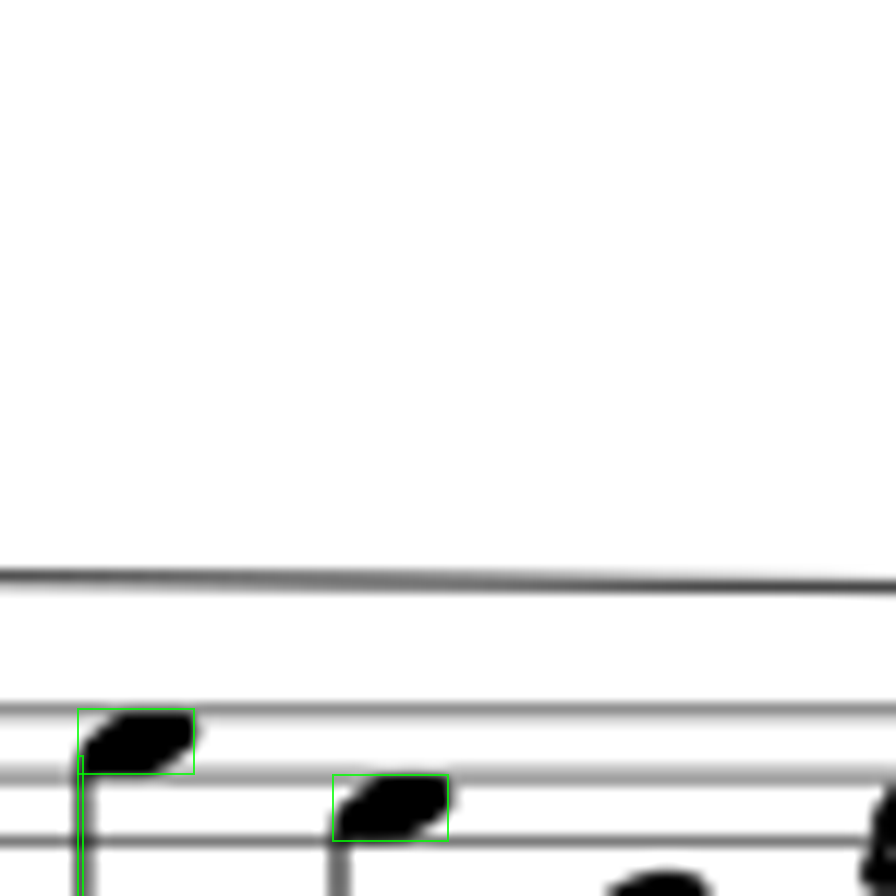

In [51]:
render_crop_gt_loc(gt_df, img_id = 895, crop_id = 8)